<a href="https://colab.research.google.com/github/mylesshin/shin-park-wildfire/blob/main/wildfire-plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install matplotlib seaborn scikit-learn 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
file_path = 'wildfiredb.csv'

# Read only the first row of the CSV file to extract the column names
with open(file_path, 'r') as f:
    df = pd.read_csv(f, nrows=10000).dropna()

filtered_df = df[df['Neighbour_frp'] != 0]
# print(filtered_df)

In [8]:
filtered_df = filtered_df.select_dtypes(include=[np.number])  # Select only numeric columns


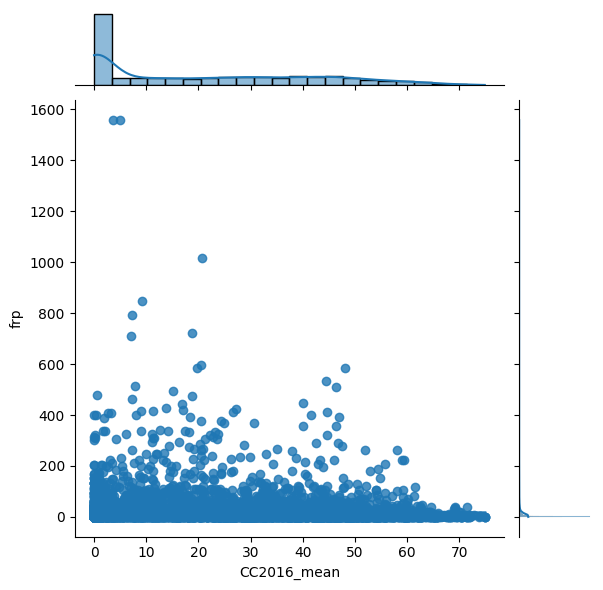

In [ ]:
sns.jointplot(x='EVH2014_mean', y='frp', data=filtered_df, kind="reg");

In [ ]:
sns.jointplot(x='Neighbour_CBC2014_min', y='frp', data=filtered_df, kind="reg");

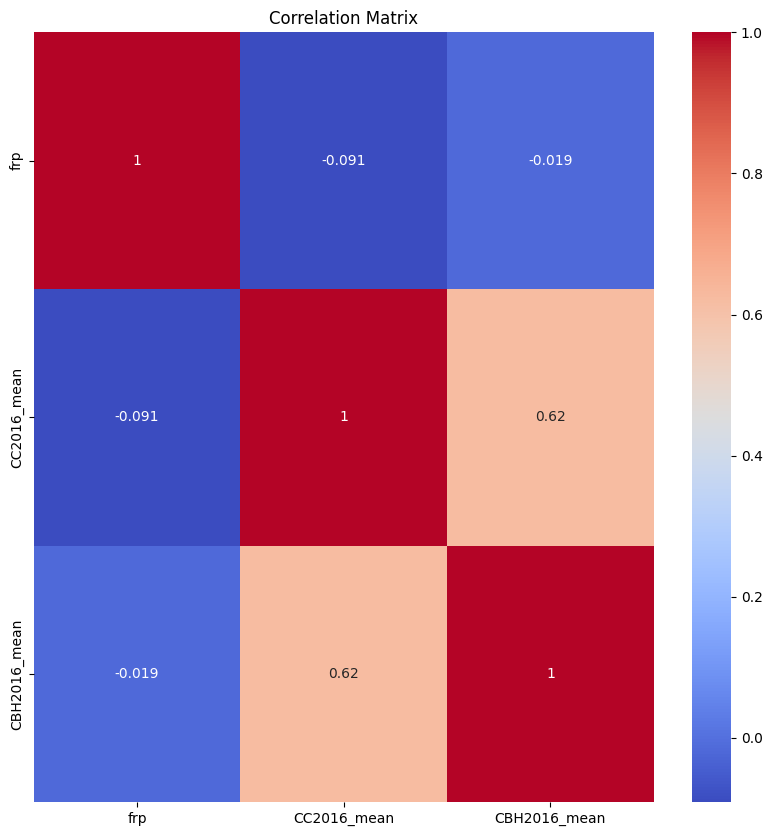

In [ ]:
subset = filtered_df[['frp', 'EVH2014_mean', 'Neighbour_CBC2014_min', 'Neighbour_CBH2012_min']]
# Calculate the correlation matrix between the remaining columns
corr_matrix = subset.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
#### Correlations and Linear Regression Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE


In [12]:
# Neighbour FRP as target variable
X = filtered_df.drop('frp', axis=1) # features
y = filtered_df['frp'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()

# Use the RFE method to select the top 5 features
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Print the top 5 features
top_5 = X_train.columns[rfe.support_]
print(top_5)


Index(['EVH2012_mean', 'EVH2014_mean', 'Neighbour_CBC2014_min',
       'Neighbour_CBH2012_min', 'Neighbour_EVC2012_mean'],
      dtype='object')


In [ ]:
# Train the model using the selected features
model.fit(X_train.loc[:, rfe.support_], y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test.loc[:, rfe.support_])

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create subplots
fig = make_subplots(rows=1, cols=2)

# Bar chart with actual and predicted values
fig.add_trace(
    go.Bar(x=X_test.index, y=y_test, name='Actual', marker_color='red'),
    row=1, col=1,
)
fig.add_trace(
    go.Bar(x=X_test.index, y=y_pred, name='Predicted', marker_color='blue'),
    row=1, col=1,
)

# Error histogram
fig.add_trace(
    go.Histogram(x=errors, nbinsx=20, marker_color='green'),
    row=1, col=2,
)

# update layout
fig.update_layout(
    title='Actual vs Predicted Values and Error Histogram',
    xaxis=dict(title='Data Points'),
    yaxis=dict(title='FRP'),
    xaxis2=dict(title='Error'),
    yaxis2=dict(title='Frequency'),
    showlegend=False,
)

# show the figure
fig.show(renderer='colab')
